In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp2wv1lxi2/pubring.gpg' created
gpg: /tmp/tmp2wv1lxi2/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
import os
os.chdir("./drive/facial_expression")
import sys
os.path.dirname(sys.executable)


'/usr/bin'

In [5]:
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
#import keras_utils_v2
from keras.preprocessing import image
from keras.utils import multi_gpu_model

from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.engine import InputLayer

1.9.0
2.1.6


Using TensorFlow backend.


In [6]:
data  = pd.read_csv("data/fer2013.csv")
print(len(data))

35887


In [0]:
data_train = data[data["Usage"]=="Training"]
#print(len(data_train))
data_test = data[data["Usage"]=="PublicTest"]
#print(data_test)

In [0]:
facial_index = {0:"Angry",1 :"Disgust",2:"Fear",3:"Happy",4:"Sad",5:"Surprise",6:"Neutral"}
def split_data(data):
    emotion = np.array(data["emotion"])
    pixels = np.array(data["pixels"])
    x = []
    for pixel in pixels:
        list_pixel = list(pixel.split(" "))
        x.append(list_pixel)
    return  np.array(x,dtype=np.float32),emotion

(28709, 2304)
Done


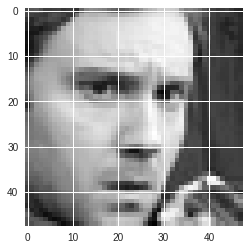

In [31]:
X_train,y_train = split_data(data_train)
print(X_train.shape)
plt.imshow(X_train[0].reshape((48, 48)), interpolation='none', cmap='gray')
#print(y_train)
X_test,y_test = split_data(data_test)
print("Done")

In [32]:

X_train = X_train/255

print(X_train.shape)   
mat = np.zeros((X_train.shape[0], X_train.shape[1]*3), dtype=float)

for img in range(0, X_train.shape[0]):
  for value in range(1, X_train.shape[1]):
    for i in range(0, 3):
      mat[img][value] = 0

print(mat.shape)   
X_test = X_test/255
X_train = X_train.reshape((-1,48,48,1))
X_test = X_test.reshape((-1,48,48,1))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


(28709, 2304)


KeyboardInterrupt: ignored

In [0]:
model = keras.applications.InceptionV3()

96124928/96112376 [==============================] - 5s 0us/step


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model.layers.pop()

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_195 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_195[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [0]:
for layer in model.layers[:-13]:
    layer.trainable = False

In [0]:
for layer in model.layers:
    print(layer, layer.trainable)

(<keras.engine.topology.InputLayer object at 0x7fd37b292b90>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37b292c90>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37b292d50>, False)
(<keras.layers.core.Activation object at 0x7fd37b20f050>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37bc01550>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37b20f990>, False)
(<keras.layers.core.Activation object at 0x7fd37bc095d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37b254d50>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37a9a8ed0>, False)
(<keras.layers.core.Activation object at 0x7fd37a999e90>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7fd37a956d90>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37a929290>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37a910450>, False)
(<keras.layers.core.Activation object at 0x7fd37a8d1850>, 

In [0]:
from keras.models import Sequential, Model
#Change input layer
input_layer = InputLayer(input_shape=(None, None, 1), name="input_1")

#Change last layer
last = model.layers[-1].output
x = Dense(256, activation="relu")(last)
x = BatchNormalization()(x)
x = Dense(7, activation="softmax")(x)
finetuned_model = Model(model.input, x)
finetuned_model.layers[0] = input_layer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
finetuned_model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])
finetuned_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_195 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_195[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [0]:
for layer in finetuned_model.layers:
    print(layer, layer.trainable)

(<keras.engine.topology.InputLayer object at 0x7fd37569bf50>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37b292c90>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37b292d50>, False)
(<keras.layers.core.Activation object at 0x7fd37b20f050>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37bc01550>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37b20f990>, False)
(<keras.layers.core.Activation object at 0x7fd37bc095d0>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37b254d50>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37a9a8ed0>, False)
(<keras.layers.core.Activation object at 0x7fd37a999e90>, False)
(<keras.layers.pooling.MaxPooling2D object at 0x7fd37a956d90>, False)
(<keras.layers.convolutional.Conv2D object at 0x7fd37a929290>, False)
(<keras.layers.normalization.BatchNormalization object at 0x7fd37a910450>, False)
(<keras.layers.core.Activation object at 0x7fd37a8d1850>, 

In [0]:
gen=image.ImageDataGenerator(rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,                        
    )
gen2=image.ImageDataGenerator(rescale=1./255)
data_train_generator = gen.flow(X_train, y_train, batch_size=128)
data_val_generator = gen2.flow(X_test,y_test,batch_size=64)


In [0]:
history = finetuned_model.fit_generator(data_train_generator,epochs=150,steps_per_epoch=128,validation_data = data_val_generator,verbose=2)

Epoch 1/150


ValueError: ignored